In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [8]:
# Load dataset
df = pd.read_csv("nba_merged.csv")

# Convert game_date to datetime and sort
df["game_date"] = pd.to_datetime(df["game_date"])
df = df.sort_values(by=["team_id.x", "game_date"])  # Ensure chronological order per team

# Drop unnecessary columns
drop_cols = ["game_id", "matchup"] # , "book_name_spread", "book_id_spread", "book_name_total", "book_id_total", "season", "season_type"
df = df.drop(columns=drop_cols)

# Encode categorical variables
df["is_home"] = df["is_home"].map({"t": 1, "f": 0})
df["wl"] = df["wl"].map({"W": 1, "L": 0})

# Select numerical features to scale (exclude actual_spread)
num_cols = ["w_pct", "fgm", "fga", "fg_pct", "fg3m", "fg3a", "fg3_pct",
            "ftm", "fta", "ft_pct", "oreb", "dreb", "reb", "ast", "stl", 
            "blk", "tov", "pf", "pts", "total1"]

# Fit scaler only on selected features
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Do NOT scale actual_spread, but keep them in the dataset
feature_cols = num_cols + ["actual_spread"]

In [21]:
# Create sequences for LSTM
X, y = [], []
time_steps = 5

for team in df["team_id.x"].unique():
    team_data = df[df["team_id.x"] == team]
    
    for i in range(len(team_data) - time_steps):
        X.append(team_data.iloc[i:i+time_steps][feature_cols].values)
        y.append(team_data.iloc[i+time_steps]["actual_spread"])  # Predict next game's spread

X = np.array(X)  # Shape: (samples, time_steps, features)
y = np.array(y)  # Shape: (samples,)

# Final LSTM input shape
print(f"Shape of X: {X.shape}")  # (samples, 10, num_features)
print(f"Shape of y: {y.shape}")  # (samples,)
X[0]

Shape of X: (29650, 5, 21)
Shape of y: (29650,)


array([[  0.        ,   0.21276596,   0.32      ,   0.19863014,
          0.16      ,   0.26666667,   0.235     ,   0.35294118,
          0.33333333,   1.        ,   0.44736842,   0.30232558,
          0.390625  ,   0.1627907 ,   0.40909091,   0.21052632,
          0.59259259,   0.51351351,   0.19626168,   0.77114428,
        -13.        ],
       [  0.5       ,   0.4893617 ,   0.37333333,   0.52511416,
          0.16      ,   0.21666667,   0.286     ,   0.37254902,
          0.47619048,   1.        ,   0.39473684,   0.25581395,
          0.328125  ,   0.30232558,   0.36363636,   0.26315789,
          0.40740741,   0.54054054,   0.44859813,   0.7960199 ,
         10.        ],
       [  0.667     ,   0.31914894,   0.25333333,   0.4086758 ,
          0.12      ,   0.1       ,   0.429     ,   0.56862745,
          0.53968254,   1.        ,   0.26315789,   0.39534884,
          0.34375   ,   0.27906977,   0.59090909,   0.21052632,
          0.55555556,   0.62162162,   0.38317757,   0.7462

In [13]:
# Load preprocessed data
print("Data Shape:", X.shape, y.shape)

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create DataLoader for batching
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Data Shape: (29200, 20, 21) (29200,)


In [82]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define dataset parameters
num_samples = 5000  # Total number of games
time_steps = 10  # Number of past games used for prediction
num_features = 22  # Number of features per game

# Generate random feature values
X_data = np.random.rand(num_samples, time_steps, num_features)

# Generate target values with variability
y_data = np.random.uniform(-10, 10, size=(num_samples,))

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)

# Split into train and test sets
train_size = int(0.8 * num_samples)
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

# Create DataLoader for batching
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [22]:
# # Define LSTM Model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size=128, num_layers=2, output_size=1, dropout=0.1):
#         super(LSTMModel, self).__init__()
#         self.lstm = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         last_out = lstm_out[:, -1, :]
#         out = self.fc(last_out)
#         return out

# # Model hyperparameters
# input_size = X.shape[2]  # Number of features
# hidden_size = 64
# num_layers = 4
# output_size = 1
# learning_rate = 0.05

# # Initialize model, loss function, optimizer
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define LSTM Model with Fixes
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, output_size=1, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.fc(last_out)
        return out

# Model hyperparameters
input_size = X.shape[2]  # Number of features
hidden_size = 128  # Increased size for better learning
num_layers = 3  # Reduced layers to avoid vanishing gradient
output_size = 1
learning_rate = 0.05  # Lower learning rate for stability
weight_decay = 0 # 1e-5

# Initialize model, loss function, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

LSTMModel(
  (lstm): LSTM(21, 128, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
# Training loop
num_epochs = 1000
train_losses = []
val_losses = []

print("Training started...")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot training loss
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("LSTM Training Loss")
plt.legend()
plt.show()

Training started...
Epoch [1/1000], Loss: 188.5282, Val Loss: 184.9589
Epoch [2/1000], Loss: 188.3787, Val Loss: 185.6287
Epoch [3/1000], Loss: 188.0562, Val Loss: 187.0549
Epoch [4/1000], Loss: 187.9688, Val Loss: 185.1344
Epoch [5/1000], Loss: 187.8793, Val Loss: 184.8056
Epoch [6/1000], Loss: 187.8872, Val Loss: 185.2371
Epoch [7/1000], Loss: 187.8872, Val Loss: 186.9885
Epoch [8/1000], Loss: 187.8389, Val Loss: 184.7690
Epoch [9/1000], Loss: 188.0224, Val Loss: 184.7374
Epoch [10/1000], Loss: 187.8333, Val Loss: 186.0885
Epoch [11/1000], Loss: 187.9871, Val Loss: 185.4301
Epoch [12/1000], Loss: 187.9208, Val Loss: 185.0058
Epoch [13/1000], Loss: 187.8998, Val Loss: 185.1027
Epoch [14/1000], Loss: 187.9344, Val Loss: 184.7720
Epoch [15/1000], Loss: 187.9048, Val Loss: 185.0114
Epoch [16/1000], Loss: 188.0682, Val Loss: 184.7416
Epoch [17/1000], Loss: 187.8242, Val Loss: 184.7512
Epoch [18/1000], Loss: 187.7798, Val Loss: 184.7393
Epoch [19/1000], Loss: 187.8037, Val Loss: 184.9493


In [18]:
# Evaluate on test data
model.eval()
test_losses = []
absolute_errors = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        test_losses.append(loss.item())

        absolute_errors.extend(torch.abs(y_pred - y_batch).cpu().numpy())

# Print test results
avg_test_loss = np.mean(test_losses)
mae = np.mean(absolute_errors)
print(f"\nTest Loss (MSE): {avg_test_loss:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Test Loss (MSE): 174.2346
Mean Absolute Error (MAE): 10.5817


Test MSE: 176.8705
Test MAE: 10.5724


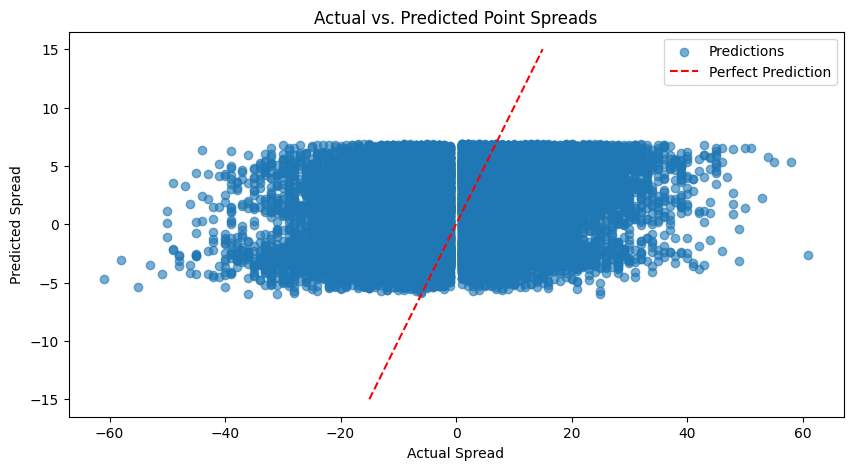

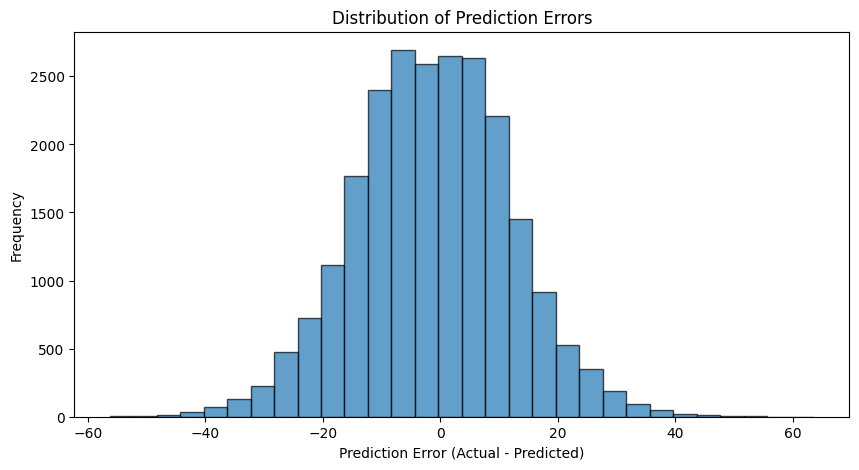

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set model to evaluation mode
model.eval()

# Store predictions and actual values
y_pred_list = []
y_actual_list = []

with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.numpy()  # Convert actual values to NumPy
        
        # Get model predictions
        y_pred = model(X_batch).cpu().numpy()

        # Store values
        y_pred_list.extend(y_pred.flatten())  
        y_actual_list.extend(y_batch.flatten())

# Convert lists to NumPy arrays
y_pred_array = np.array(y_pred_list)
y_actual_array = np.array(y_actual_list)

# Compute evaluation metrics
mse = mean_squared_error(y_actual_array, y_pred_array)
mae = mean_absolute_error(y_actual_array, y_pred_array)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")

# Scatter plot: Actual vs. Predicted spreads
plt.figure(figsize=(10, 5))
plt.scatter(y_actual_array, y_pred_array, alpha=0.6, label="Predictions")
plt.plot([-15, 15], [-15, 15], color='red', linestyle='dashed', label="Perfect Prediction")
plt.xlabel("Actual Spread")
plt.ylabel("Predicted Spread")
plt.title("Actual vs. Predicted Point Spreads")
plt.legend()
plt.show()

# Histogram of Prediction Errors
plt.figure(figsize=(10, 5))
errors = y_actual_array - y_pred_array
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

In [86]:
print(min(y_actual_array), max(y_actual_array))
min(y_pred_array), max(y_pred_array)

-9.997802 9.995241


(-1.1921189, -1.1921186)

In [21]:
test_loader
for X_batch, y_batch in test_loader:
    print(X_batch)
    print(y_batch)
    break  # Remove this line if you want to iterate through the entire DataLoader

tensor([[[0.6930, 0.5319, 0.2267,  ..., 0.8765, 0.7761, 0.7761],
         [0.6970, 0.5532, 0.3067,  ..., 0.8395, 0.8109, 0.8109],
         [0.7010, 0.5532, 0.2800,  ..., 0.8272, 0.7761, 0.7761],
         ...,
         [0.7070, 0.4468, 0.3600,  ..., 0.4444, 0.7587, 0.7587],
         [1.0000, 0.3191, 0.2667,  ..., 0.2963, 0.7264, 0.7264],
         [1.0000, 0.3830, 0.2400,  ..., 0.3333, 0.7239, 0.7239]],

        [[0.5560, 0.5106, 0.4400,  ..., 0.5432, 0.7040, 0.7040],
         [0.6000, 0.3830, 0.3467,  ..., 0.4074, 0.7264, 0.7264],
         [0.6360, 0.5106, 0.4133,  ..., 0.4321, 0.6915, 0.6915],
         ...,
         [0.6250, 0.5957, 0.4267,  ..., 0.6543, 0.7164, 0.7164],
         [0.5880, 0.4255, 0.3733,  ..., 0.4074, 0.6891, 0.6891],
         [0.5560, 0.4043, 0.3867,  ..., 0.4938, 0.7139, 0.7139]],

        [[0.2000, 0.2766, 0.2933,  ..., 0.3086, 0.7612, 0.7612],
         [0.3330, 0.3830, 0.3600,  ..., 0.2840, 0.7040, 0.7040],
         [0.2500, 0.5532, 0.4267,  ..., 0.6420, 0.7886, 0.